In [2]:
import datetime
import numpy as np
import pandas_datareader.data as pdr

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.pipeline import Pipeline

In [43]:
## Downloads selected FRED indicators from start and end dates

start = "1970-01-01"
end = datetime.date.today()

def pct_change_on_last_year(df):
    "compute pct_change on previous year, assuming quarterly"
    return (df - df.shift(4))/df.shift(4)

def get_indicators_from_fred(start=start, end=end):
    """
    Fetch quarterly data on 6 leading indicators from time period start:end
    """
    # yield curve, unemployment, change in inventory, new private housing permits
    df1 = (
        pdr.DataReader(
        ["T10Y2Y", "UNRATE", "CBIC1", "PERMIT"], "fred", start, end)
        .resample("QS")
        .mean()
    )

    # percent change in housing prices and retail sales
    df2 = (
        pdr.DataReader(
        ["USSTHPI", "USASLRTTO01GYSAM"], "fred", start, end)
        .resample("QS")  # already quarterly, adjusting so index is same
        .mean()
        .pipe(pct_change_on_last_year)
        .dropna()
    )

    indicators = (
        df1
        .join(df2)
        .dropna()
        .rename(columns=dict(
            USSTHPI="pct_change_hpi",
            T10Y2Y="yield_curve",
            UNRATE="unemp",
            CBIC1="inventory",
            USASLRTTO01GYSAM="retail_sales",
            PERMIT="house_permits"
        ))
    )

    return indicators

indicators = get_indicators_from_fred()

In [31]:
indicators.tail

<bound method NDFrame.tail of             yield_curve     unemp  inventory  house_permits  pct_change_hpi  \
DATE                                                                          
1976-04-01     0.801364  7.566667     58.961    1171.333333        0.072447   
1976-07-01     1.099687  7.733333     53.269    1345.000000        0.087447   
1976-10-01     1.467377  7.766667     19.461    1489.000000        0.080013   
1977-01-01     1.332222  7.500000     33.147    1562.000000        0.105456   
1977-04-01     1.248254  7.133333     49.461    1693.333333        0.111570   
...                 ...       ...        ...            ...             ...   
2022-07-01    -0.281094  3.533333     70.681    1610.666667        0.163613   
2022-10-01    -0.560656  3.566667    151.902    1455.333333        0.116513   
2023-01-01    -0.696452  3.500000     27.165    1424.333333        0.081990   
2023-04-01    -0.668571  3.566667     14.928    1451.333333        0.045946   
2023-07-01    -0.76698

In [54]:
### Gets recession start and end dates

def get_recession_data():
    recession = (
        pdr.DataReader(["USRECQ"], "fred", start, end)
        .rename(columns=dict(USRECQ="recession"))
        ["recession"]
    )

    # extract start and end date for each recession
    start_dates = recession.loc[recession.diff() > 0].index.tolist()
    if recession.iloc[0] > 0:
        start_dates = [recession.index[0]] + start_dates

    end_dates = recession.loc[recession.diff() < 0].index.tolist()

    n_starts = len(start_dates)
    n_ends = len(end_dates)
    if not( (n_starts == n_ends) or (n_starts == n_ends + 1) ):
        # if the last date is stil within a recession then n_starts = n_ends + 1
        raise ValueError("Need to have same number of start/end dates!")

    return recession, start_dates, end_dates

recession, start_dates, end_dates = get_recession_data()

In [55]:
recession.tail

<bound method NDFrame.tail of DATE
1970-01-01    1
1970-04-01    1
1970-07-01    1
1970-10-01    1
1971-01-01    0
             ..
2022-10-01    0
2023-01-01    0
2023-04-01    0
2023-07-01    0
2023-10-01    0
Name: recession, Length: 216, dtype: int64>

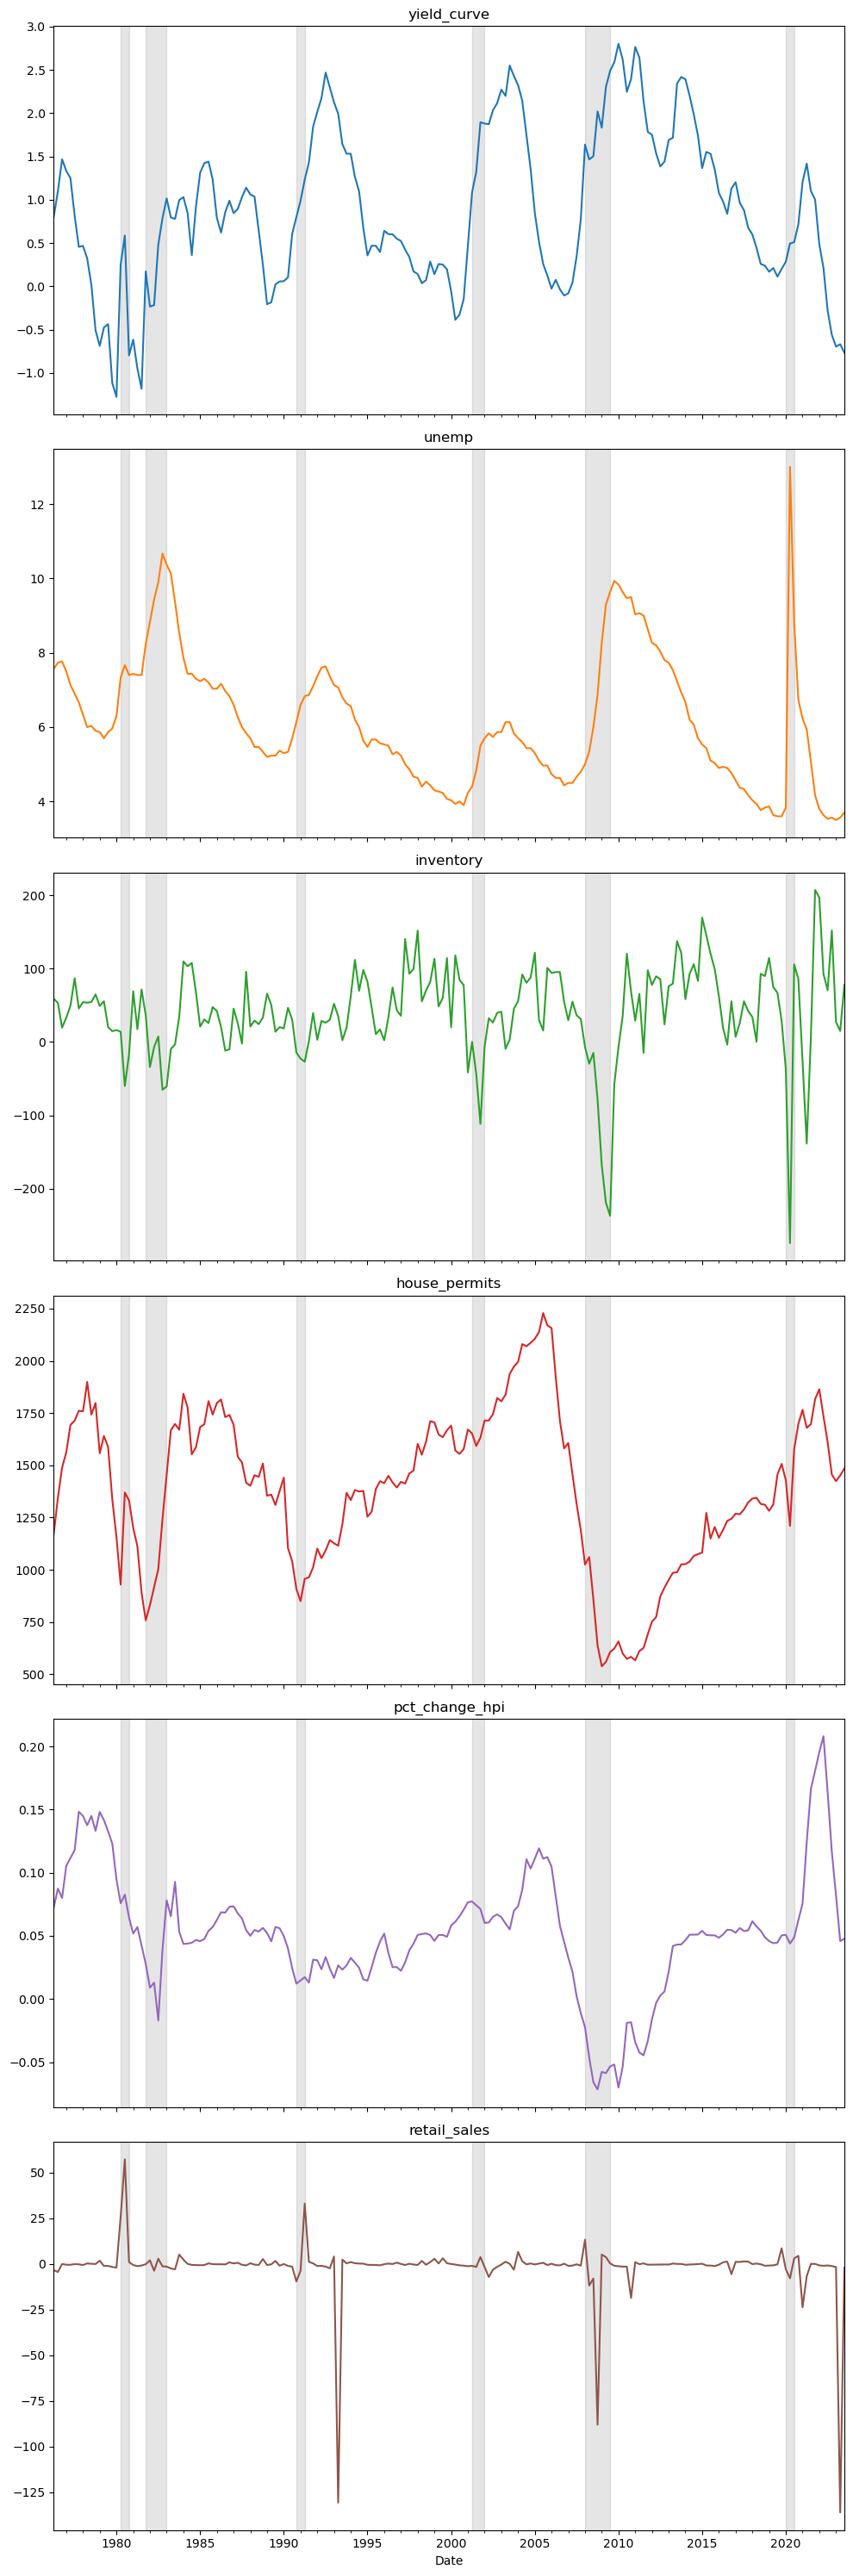

In [72]:
def add_recession_bands(ax):
    for s, e in zip(start_dates, end_dates):
        ax.axvspan(s, e, color="grey", alpha=0.2)

axs = indicators.plot(
    subplots=True, figsize=(10, 30), layout=(6, 1), legend=False)

for i, ax in enumerate(axs.flatten()):
    if i < len(indicators.columns):
        add_recession_bands(ax)
        ax.set_title(indicators.columns[i])
     # Set x-axis label for each subplot
        ax.set_xlabel('Date')   

fig = axs[0, 0].get_figure()
fig.tight_layout();

In [83]:
def make_inputs_and_targets(indicators, recessions, horizon=1):
    return indicators.join(recessions.shift(horizon)).dropna()

In [84]:
df = make_inputs_and_targets(indicators, recession)

In [80]:
df.to_csv('recession.txt', sep='\t', index=True, columns=df.columns.tolist())

In [85]:
df.head

<bound method NDFrame.head of             yield_curve     unemp  inventory  house_permits  pct_change_hpi  \
DATE                                                                          
1976-04-01     0.801364  7.566667     58.961    1171.333333        0.072447   
1976-07-01     1.099687  7.733333     53.269    1345.000000        0.087447   
1976-10-01     1.467377  7.766667     19.461    1489.000000        0.080013   
1977-01-01     1.332222  7.500000     33.147    1562.000000        0.105456   
1977-04-01     1.248254  7.133333     49.461    1693.333333        0.111570   
...                 ...       ...        ...            ...             ...   
2022-07-01    -0.281094  3.533333     70.681    1610.666667        0.163613   
2022-10-01    -0.560656  3.566667    151.902    1455.333333        0.116513   
2023-01-01    -0.696452  3.500000     27.165    1424.333333        0.081990   
2023-04-01    -0.668571  3.566667     14.928    1451.333333        0.045946   
2023-07-01    -0.76698

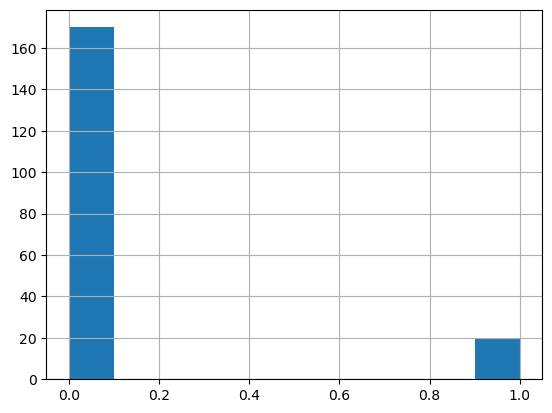

In [50]:
df.recession.hist();

In [89]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [91]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', LinearSVC(dual=False)),
])

In [93]:
accs = []
f1s = []
precisions = []
recalls = []
for i in range(100):
  X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)
  pipe.fit(X_train, y_train)
  acc = pipe.score(X_test, y_test)
  p = pipe.predict(X_test)
  f1 = f1_score(y_test, p)
  prec = precision_score(y_test, p, zero_division=1)
  rec = recall_score(y_test, p)
  accs.append(acc)
  f1s.append(f1)
  precisions.append(prec)
  recalls.append(rec)

In [94]:
np.mean(accs), np.mean(f1s), np.mean(precisions), np.mean(recalls)

(0.9349999999999998, 0.6232178932178931, 0.775079365079365, 0.5599999999999999)